In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from PIL import Image

#Escolhendo GPU: no caso de rodar no srv multigpu, escolher 0 ou 1
#Não pareceu funcionar
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#Reports
from sklearn.metrics import classification_report, confusion_matrix
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [2]:
vgg16_model=keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)

In [3]:
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)

In [4]:
model = Model(inputs=vgg16_model.input,output=preds)

In [5]:
BATCH_SIZE = 32
TRAINING_DIR = '/home/jailsonpereira/paic/dataset_2/treino/'

In [6]:
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.1)

train_generator=data_generator.flow_from_directory(TRAINING_DIR,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True,subset='training')

validation_generator=data_generator.flow_from_directory(TRAINING_DIR,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=True,subset='validation')

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

Found 1080 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [7]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

In [8]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='CNN_Ince_aval_7.0_best_model.h5', #.{epoch:02d}-{val_loss:.2f}
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

In [9]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=250,
        callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/250
33/33 [==============================] - 21s 622ms/step - loss: 7.8669 - acc: 0.5019 - val_loss: 8.2269 - val_acc: 0.4896

Epoch 00001: val_loss improved from inf to 8.22694, saving model to CNN_Ince_aval_7.0_best_model.h5
Epoch 2/250
33/33 [==============================] - 19s 574ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 7.8759 - val_acc: 0.5114

Epoch 00002: val_loss improved from 8.22694 to 7.87589, saving model to CNN_Ince_aval_7.0_best_model.h5
Epoch 3/250
33/33 [==============================] - 19s 585ms/step - loss: 8.0689 - acc: 0.4994 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 7.87589
Epoch 4/250
33/33 [==============================] - 19s 582ms/step - loss: 8.0083 - acc: 0.5031 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 7.87589
Epoch 5/250
33/33 [==============================] - 20s 618ms/step - loss: 8.1861 - acc: 0.4921 - val_loss: 8.2269 - val_acc: 0.4896

Epoch 00005: val_lo

33/33 [==============================] - 17s 522ms/step - loss: 8.0384 - acc: 0.5013 - val_loss: 7.5096 - val_acc: 0.5341

Epoch 00044: val_loss did not improve from 6.59377
Epoch 45/250
33/33 [==============================] - 21s 622ms/step - loss: 8.1704 - acc: 0.4931 - val_loss: 8.8985 - val_acc: 0.4479

Epoch 00045: val_loss did not improve from 6.59377
Epoch 46/250
33/33 [==============================] - 20s 601ms/step - loss: 7.7744 - acc: 0.5177 - val_loss: 7.6927 - val_acc: 0.5227

Epoch 00046: val_loss did not improve from 6.59377
Epoch 47/250
33/33 [==============================] - 19s 572ms/step - loss: 8.2571 - acc: 0.4877 - val_loss: 7.5096 - val_acc: 0.5341

Epoch 00047: val_loss did not improve from 6.59377
Epoch 48/250
33/33 [==============================] - 20s 606ms/step - loss: 8.2575 - acc: 0.4877 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00048: val_loss did not improve from 6.59377
Epoch 49/250
33/33 [==============================] - 20s 594ms/step - loss: 7

### FALTA AVALIAR

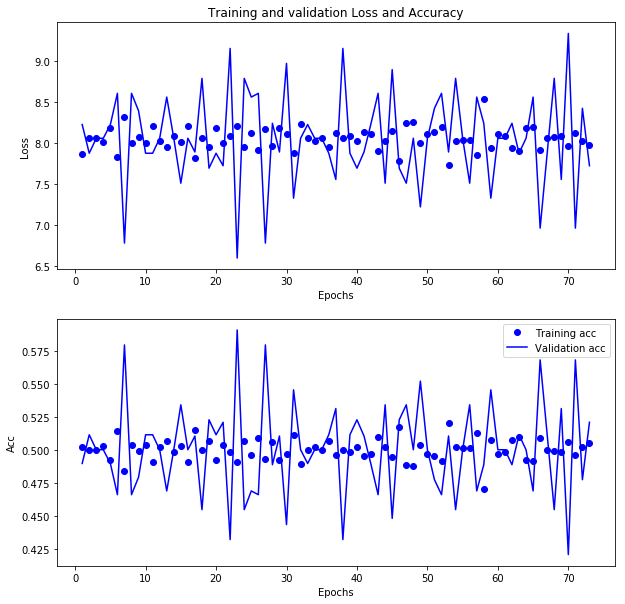

In [10]:
#Visualização do treino
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
loss_values[116]

# Avaliação

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
model = load_model('CNN_Ince_aval_7.0_best_model.h5')

In [13]:
test_dir = '../dataset_2/teste'
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

Found 400 images belonging to 2 classes.


In [14]:
predict = model.predict_generator(test_generator,steps = nb_samples)

In [15]:
y_pred = np.argmax(predict,axis=1)


In [16]:
len(y_pred)

400

In [17]:
print(confusion_matrix(test_generator.classes,y_pred))

[[  0 200]
 [  0 200]]


In [18]:
#!pip install seaborn

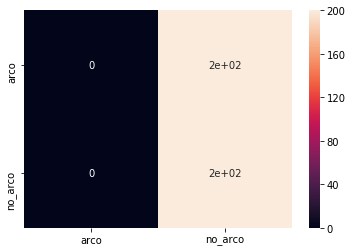

In [19]:
#Confusion MKatrix
import seaborn as sns
classes = 'arco no_arco'.split()
sns.heatmap(confusion_matrix(test_generator.classes,y_pred),annot=True, xticklabels=classes, yticklabels=classes)

In [20]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=classes))

Classification Report
              precision    recall  f1-score   support

        arco       0.00      0.00      0.00       200
     no_arco       0.50      1.00      0.67       200

   micro avg       0.50      0.50      0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



In [21]:
#t_ini = time.time()
#y_pred = model.predict_generator(x_test)
#t_fim = time.time()
print("Total de exemplos: "+ str(len(test_generator)))
#print("Tempo por exemplo: "+str((t_fim - t_ini)/len(x_test)))

#model.predict_generator(test_generator,steps = nb_samples)

score = model.evaluate_generator(test_generator, steps = nb_samples)
print('Loss de Teste:', score[0])
print('Acurácia de Teste:', score[1])

Total de exemplos: 400
Loss de Teste: 8.059047758579261
Acurácia de Teste: 0.5


In [ ]:
score = history.model.evaluate_generator(train_generator,steps=nb_train_samples)